# Downloading Sentinel3 L2 - chl_nn data
https://github.com/wekeo/wekeo4oceans

Following the tutorial that Henrik provided to download the data via the API

In [ ]:
import configparser # a library that allows us to parse standard configuration files
import IPython      # a library that helps us display video and HTML content
import os           # a library that allows us access to basic operating system commands like making directories
import json         # a library that helps us make JSON format files
import shutil       # a library that allows us access to basic operating system commands like copy
import zipfile      # a library that allows us to unzip zip-files.
!python -m pip install eumdac
import eumdac       # a tool that helps us download via the eumetsat/data-store
import datetime
import xarray as xr
from shapely import geometry # a library that support construction of geometry objects
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
!python -m pip install cartopy
import cartopy.crs as ccrs 
import matplotlib.ticker as mticker
from osgeo import gdal, osr
!pip install netCDF4
from netCDF4 import Dataset
from shapely.geometry import box, shape
!pip install geojson
import geojson
import multiprocessing as mp
from skimage import io as skio
import cftime
import dotenv
dotenv.load_dotenv("dev.env")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
download_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_olci'
os.makedirs(download_dir, exist_ok=True)

In [ ]:
print(download_dir)

/content/drive/MyDrive/MasterThesis/Data/CHL_olci


In [ ]:
consumer_key = os.getenv("EUMETSAT_API_KEY")
consumer_secret = os.getenv("EUMETSAT_API_SECRET")
token = eumdac.AccessToken((consumer_key, consumer_secret))

In [ ]:
# create data store object
datastore = eumdac.DataStore(token)

In [ ]:
for collection_id in datastore.collections:
    if "OLCI" in collection_id.title:
        print(f"Collection ID({collection_id}): {collection_id.title}")

Collection ID(EO:EUM:DAT:0410): OLCI Level 1B Reduced Resolution - Sentinel-3
Collection ID(EO:EUM:DAT:0408): OLCI Level 2 Ocean Colour Reduced Resolution - Sentinel-3
Collection ID(EO:EUM:DAT:0409): OLCI Level 1B Full Resolution - Sentinel-3
Collection ID(EO:EUM:DAT:0592): OLCI Level 2 Ocean Colour Full Resolution (version BC002) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0556): OLCI Level 2 Ocean Colour Full Resolution (version BC003) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0557): OLCI Level 2 Ocean Colour Reduced Resolution (version BC003) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0407): OLCI Level 2 Ocean Colour Full Resolution - Sentinel-3
Collection ID(EO:EUM:DAT:0593): OLCI Level 2 Ocean Colour Reduced Resolution (version BC002) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0577): OLCI Level 1B Full Resolution (version BC002) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0578): OLCI Level 1B Reduced Resolution (version BC002) - Sentinel

In [ ]:
collection_id = 'EO:EUM:DAT:0557'
selected_collection = datastore.get_collection(collection_id)

In [ ]:
product_list = [
'S3A_OL_1_EFR____20210717T101015_20210717T101315_20210718T145224_0179_074_122_1980_MAR_O_NT_002.SEN3',
'S3A_OL_2_WRR____20210717T095732_20210717T104152_20210718T152419_2660_074_122______MAR_O_NT_003.SEN3',
'S3A_OL_2_WFR____20210717T101015_20210717T101315_20210718T221347_0179_074_122_1980_MAR_O_NT_003.SEN3'
]

In [ ]:
collection_ids = ["EO:EUM:DAT:0408", "EO:EUM:DAT:0407"]

for product_id, collection_id in zip(product_list[1:],collection_ids):
    print(f"Retrieving: {product_id}")    

    selected_collection = datastore.get_collection(collection_id)
    selected_product = datastore.get_product(product_id=product_id, collection_id=collection_id)
    
    with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
        print(f'Downloading {fsrc.name}.')
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of product {fsrc.name} finished.')

    with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith(str(selected_product)):
                zip_ref.extract(file, download_dir)
        print(f'Unzipping of product {fdst.name} finished.')

    os.remove(fdst.name)

Retrieving: S3A_OL_2_WRR____20210717T095732_20210717T104152_20210718T152419_2660_074_122______MAR_O_NT_003.SEN3
Download of product S3A_OL_2_WRR____20210717T095732_20210717T104152_20210718T152419_2660_074_122______MAR_O_NT_003.SEN3.zip finished.
Unzipping of product /content/drive/MyDrive/MasterThesis/Data/CHL_OLCI/S3A_OL_2_WRR____20210717T095732_20210717T104152_20210718T152419_2660_074_122______MAR_O_NT_003.SEN3.zip finished.
Retrieving: S3A_OL_2_WFR____20210717T101015_20210717T101315_20210718T221347_0179_074_122_1980_MAR_O_NT_003.SEN3
Download of product S3A_OL_2_WFR____20210717T101015_20210717T101315_20210718T221347_0179_074_122_1980_MAR_O_NT_003.SEN3.zip finished.
Unzipping of product /content/drive/MyDrive/MasterThesis/Data/CHL_OLCI/S3A_OL_2_WFR____20210717T101015_20210717T101315_20210718T221347_0179_074_122_1980_MAR_O_NT_003.SEN3.zip finished.


## Code to only access the CHL Data

In [ ]:
# set collection ID for OLCI L2 WFR
collectionID = 'EO:EUM:DAT:0556' 

In [ ]:
# Use collection ID
selected_collection = datastore.get_collection(collectionID)
print(selected_collection.title)

OLCI Level 2 Ocean Colour Full Resolution (version BC003) - Sentinel-3 - Reprocessed


In [ ]:
# space/time filter the collection for products
north = 65.85
south = 53.25
east = 30.25
west = 9.25
ROI = [[west, south], [east, south], [east, north], [west, north], [west, south]]
ROI_WKT = geometry.Polygon([[p[0], p[1]] for p in ROI])

In [ ]:
# set filter for time
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2021,4,29)

In [ ]:
def warp_s3(s3_folder,
            geo_file,
            chl_nn_file,
            output_dir,
            geo_region=None,
            reproject=None,
            resolution=None,
            vrt_bands=None,
            extent_intersect=True,
            output_type="SDR"):

    fid = Dataset(os.path.join(s3_folder, geo_file), 'r', format="NETCDF4")
    min_lat, max_lat, min_lon, max_lon = [fid['latitude'][...].min(),
                                          fid['latitude'][...].max(),
                                          fid['longitude'][...].min(),
                                          fid['longitude'][...].max()]

    ysize, xsize = fid['latitude'][...].shape

    driver = gdal.GetDriverByName("GTiff")
    lat_file = os.path.join(output_dir, 'lat.tif')
    tif = driver.Create(lat_file, xsize, ysize, 1, gdal.GDT_Float32)

    tif.GetRasterBand(1).WriteArray(fid['latitude'][...])
    tif.FlushCache()

    lon_file = os.path.join(output_dir, 'lon.tif')
    tif = driver.Create(lon_file, xsize, ysize, 1, gdal.GDT_Float32)

    tif.GetRasterBand(1).WriteArray(fid['longitude'][...])
    tif.FlushCache()
    del tif
    del fid

    proj = osr.SpatialReference()
    proj.ImportFromEPSG(4326)
    proj = proj.ExportToWkt()

    extent = box(min_lon, min_lat, max_lon, max_lat, ccw=True)
    warp_options = {'geoloc': True,
                    'dstSRS': proj,
                    'multithread': True,
                    'resampleAlg': 'bilinear',
                    'warpOptions': ['SAMPLE_STEPS=21',
                                    'SOURCE_EXTRA=0',
                                    "NUM_THREADS=%i" % mp.cpu_count()]}

    datedir = os.path.basename(output_dir)
    if geo_region:
        with open(geo_region) as a:
            g2 = geojson.load(a)

        try:
            g2 = shape(g2[0]["geometry"])
        except KeyError:
            g2 = shape(g2["geometry"])
        if extent_intersect:
            g2 = g2.intersection(extent)

        warp_options['outputBounds'] = g2.bounds
        warp_options['outputBoundsSRS'] = proj

    if reproject:
        warp_options['dstSRS'] = reproject
    if resolution:
        warp_options['xRes'] = resolution
        warp_options['yRes'] = -resolution
    temp_file = os.path.join(output_dir, 'temp.tif')

    dataset, variables = (chl_nn_file, ['CHL_NN'])

    input_product = os.path.join(s3_folder, dataset)

    fid = Dataset(input_product, 'r', format="NETCDF4")
    for i, var in enumerate(variables):
        output_file = os.path.join(output_dir, 'S3_%s_%s.tif' % (datedir, var))
        tif = driver.Create(temp_file, xsize, ysize, 1, gdal.GDT_Float32)

        print('Processing %s:%s' % (dataset, var))
        b = tif.GetRasterBand(1)
        values = fid[var][...].data
        if "flag" not in var:
            no_data_value = fid[var]._FillValue
            values[values == no_data_value] = np.nan
        b.WriteArray(values)
        b.SetNoDataValue(np.nan)
        
        b.FlushCache()
        geolocArray = {}
        geolocArray['SRS'] = proj
        geolocArray['X_DATASET'] = lon_file
        geolocArray['Y_DATASET'] = lat_file
        geolocArray['X_BAND'] = str(1)
        geolocArray['Y_BAND'] = str(1)
        geolocArray['LINE_OFFSET'] = str(0)
        geolocArray['LINE_STEP'] = str(1)
        geolocArray['PIXEL_OFFSET'] = str(0)
        geolocArray['PIXEL_STEP'] = str(1)
        geolocArray['GEOREFERENCING_CONVENTION'] = 'PIXEL_CENTER'
        tif.SetMetadata(geolocArray, 'GEOLOCATION')
        tif.FlushCache()
        del tif

        print('Projecting file')
        if "flag" in var:
            warp_options["resampleAlg"] = "near"
        gdal.Warp(output_file, temp_file, **warp_options)

    del fid

    os.remove(temp_file)
    os.remove(lat_file)
    os.remove(lon_file)

    return output_file

In [ ]:
def write_tiff_to_nc(file, download_dir, time):
  # Open the TIFF file
  ds = gdal.Open(file)

  # Get the number of rows and columns
  rows = ds.RasterYSize
  cols = ds.RasterXSize

  # Get the geotransform
  gt = ds.GetGeoTransform()

  # Calculate the latitude and longitude coordinates for each pixel
  lon = np.arange(cols)*gt[1]+gt[0]
  lat = np.arange(rows)*gt[5]+gt[3]

  # Create a NetCDF file
  nc = Dataset(f'{download_dir}/file.nc', 'w', format='NETCDF4')

  # Define the dimensions
  lat_dim = nc.createDimension('lat', rows)
  lon_dim = nc.createDimension('lon', cols)
  time_dim = nc.createDimension('time', None)

  # Define the latitude variable
  lat_var = nc.createVariable('lat', np.float32, ('lat',))
  lat_var.units = 'degrees_north'
  lat_var.long_name = 'latitude'
  lat_var[:] = lat

  # Define the longitude variable
  lon_var = nc.createVariable('lon', np.float32, ('lon',))
  lon_var.units = 'degrees_east'
  lon_var.long_name = 'longitude'
  lon_var[:] = lon

  # Define the time variable
  time_var = nc.createVariable('time', np.float64, ('time',))
  time_var.units = 'days since 1900-01-01 00:00:00'
  time_var.calendar = 'standard'
  time_var.long_name = 'time'

  # Define the data variable
  data_var = nc.createVariable('data', np.float32, ('time', 'lat', 'lon'), fill_value=-9999)
  data_var.units = 'units'
  data_var.long_name = 'data'

  # Read the data from the TIFF file
  data = ds.GetRasterBand(1).ReadAsArray()

  # Write the data to the NetCDF file
  data_var[0, :, :] = data  # replace 0 with the index of the time dimension

  # Write the time to the NetCDF file
  t = (time - datetime.datetime(1900, 1, 1)).total_seconds() / (24 * 60 * 60)
  time_var[0] = t  # replace 0.0 with the time value in days since 1900-01-01

  # Close the NetCDF file
  nc.close()

In [ ]:
def rescale_nc_file(multi, download_dir, output_name, time):
  file = xr.open_dataset(f'{download_dir}/file.nc')
  # Interpolate the data from ds1['variable'] to the grid of ds2, using the nearest grid point
  interpolated = file['data'].interp(coords={'lat':multi['lat'], 'lon': multi['lon']}, method='nearest')

  # write data to final nc file
  # Create a NetCDF file
  nc = Dataset(f'{download_dir}/{output_name}', 'w', format='NETCDF4')


  # Define the dimensions
  lat_dim = nc.createDimension('lat', interpolated.shape[1])
  lon_dim = nc.createDimension('lon', interpolated.shape[2])
  time_dim = nc.createDimension('time', None)

  # Define the latitude variable
  lat_var = nc.createVariable('lat', np.float32, ('lat',))
  lat_var.units = 'degrees_north'
  lat_var.long_name = 'latitude'
  lat_var[:] = interpolated.lat

  # Define the longitude variable
  lon_var = nc.createVariable('lon', np.float32, ('lon',))
  lon_var.units = 'degrees_east'
  lon_var.long_name = 'longitude'
  lon_var[:] = interpolated.lon

  # Define the time variable
  time_var = nc.createVariable('time', np.float64, ('time',))
  time_var.units = 'days since 1900-01-01 00:00:00'
  time_var.calendar = 'standard'
  time_var.long_name = 'time'

  # Define the data variable
  data_var = nc.createVariable('data', np.float32, ('time', 'lat', 'lon'), fill_value=-9999)
  data_var.units = 'units'
  data_var.long_name = 'data'
  # Write the data to the NetCDF file
  data_var[0,:,:] = interpolated[0,:,:]  # replace 0 with the index of the time dimension
  # Write the time to the NetCDF file
  t = (time - datetime.datetime(1900, 1, 1)).total_seconds() / (24 * 60 * 60)
  time_var[0] = t  # replace 0.0 with the time value in days since 1900-01-01

  # Close the NetCDF file
  nc.close()

In [ ]:
products = selected_collection.search(
    geo=ROI_WKT,
    dtstart=start, 
    dtend=end)

In [ ]:
products

<class 'eumdac.collection.SearchResults'>(EO:EUM:DAT:0556, {'timeliness': None, 'relorbit': None, 'type': None, 'geo': 'POLYGON ((9.25 53.25, 30.25 53.25, 30.25 65.85, 9.25 65.85, 9.25 53.25))', 'sat': None, 'orbit': None, 'dtend': '2021-04-29T00:00:00', 'bbox': None, 'zone': None, 't6': None, 'set': None, 'title': None, 'sort': None, 'cycle': None, 'dtstart': '2016-01-01T00:00:00', 'publication': None})

In [ ]:
# space/time filter the collection for products
selected_collection = datastore.get_collection(collectionID)

# reduce resolution
#grid_reduce = 100
products = selected_collection.search(
    geo=ROI_WKT,
    dtstart=start, 
    dtend=end)
path = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km'
multi_path = f"{path}/CHL_data_152016_to_2152016.nc"
multi = xr.open_dataset(multi_path)

timecheck = 0
chlcheck = 0
geocheck = 0
for product in products:
  name = str(product).split('.')[0]

  try: 
  
    for entry in product.entries:
        # download the data
        if 'chl_nn' in entry: 
            with product.open(entry=entry) as fsrc, open(os.path.join(download_dir,f'{name}_chl_nn.nc'),
                                                        mode='wb') as fdst:
                print(f'Downloading {fsrc.name}.')
                shutil.copyfileobj(fsrc, fdst)
                print(f'Download of file {fsrc.name} finished.')

            chlcheck += 1
        if 'geo_coordinates' in entry and not 'tie' in entry: 
            with product.open(entry=entry) as fsrc, open(os.path.join(download_dir,f'{name}_geo_coordinates.nc'),
                                                        mode='wb') as fdst:
                print(f'Downloading {fsrc.name}.')
                shutil.copyfileobj(fsrc, fdst)
                print(f'Download of file {fsrc.name} finished.')
            geocheck += 1

        if 'time_coordinates' in entry: 
            with product.open(entry=entry) as fsrc, open(os.path.join(download_dir,f'{name}_time_coordinates.nc'),
                                                        mode='wb') as fdst:
                print(f'Downloading {fsrc.name}.')
                shutil.copyfileobj(fsrc, fdst)
                print(f'Download of file {fsrc.name} finished.')
            timecheck += 1

    if geocheck == 1 and timecheck == 1 and chlcheck == 1:
      time_fid = xr.open_dataset(os.path.join(download_dir,f'{name}_time_coordinates.nc'))
      time = time_fid.get('time_stamp').data
      time_pd = pd.to_datetime(time)
      time_np = time_pd.astype(np.int64)
      average_time_np = np.average(time_np)

      average_time_pd = pd.to_datetime(average_time_np)
      print(average_time_pd)

      file = warp_s3(download_dir, 
                f'{name}_geo_coordinates.nc', 
                f'{name}_chl_nn.nc',
                download_dir)
      # write to temporary nc file
      write_tiff_to_nc(file, download_dir, average_time_pd)

      # reqrite to final nc file
      rescale_nc_file(multi, download_dir, f'{name}_chl_final.nc', average_time_pd)
      
      # remove the temporary files
      os.remove(f'{download_dir}/file.nc')
      os.remove(file)

    if geocheck == 1:
      os.remove(os.path.join(download_dir,f'{name}_geo_coordinates.nc'))
      geocheck = 0
    if timecheck == 1:
      os.remove(os.path.join(download_dir,f'{name}_time_coordinates.nc'))
      timecheck = 0
    if chlcheck == 1:
      os.remove(os.path.join(download_dir,f'{name}_chl_nn.nc'))
      chlcheck = 0
  except:
    if geocheck == 1:
      os.remove(os.path.join(download_dir,f'{name}_geo_coordinates.nc'))
      geocheck = 0
    if timecheck == 1:
      os.remove(os.path.join(download_dir,f'{name}_time_coordinates.nc'))
      timecheck = 0
    if chlcheck == 1:
      os.remove(os.path.join(download_dir,f'{name}_chl_nn.nc'))
      chlcheck = 0

Streaming output truncated to the last 5000 lines.
Projecting file
Download of file time_coordinates.nc finished.
Download of file chl_nn.nc finished.
Download of file geo_coordinates.nc finished.
2021-02-22 10:29:28.101639168
Processing S3B_OL_2_WFR____20210222T102749_20210222T103031_20210904T144456_0162_049_222______MAR_R_NT_003_chl_nn.nc:CHL_NN
Projecting file
Download of file chl_nn.nc finished.
Download of file time_coordinates.nc finished.
Download of file geo_coordinates.nc finished.
2021-02-22 09:30:47.854798336
Processing S3A_OL_2_WFR____20210222T092900_20210222T093200_20210903T162742_0180_068_364______MAR_R_NT_003_chl_nn.nc:CHL_NN
Projecting file
Download of file chl_nn.nc finished.
Download of file geo_coordinates.nc finished.
Download of file time_coordinates.nc finished.
2021-02-22 09:27:56.778008320
Processing S3A_OL_2_WFR____20210222T092618_20210222T092900_20210903T163619_0162_068_364______MAR_R_NT_003_chl_nn.nc:CHL_NN
Projecting file
Download of file geo_coordinates.nc 

In [ ]:
file = warp_s3(download_dir, 
               'S3B_OL_2_WFR____20210717T093051_20210717T093351_20210718T215248_0179_054_364_1980_MAR_O_NT_003_geo_coordinates.nc', 
               'S3B_OL_2_WFR____20210717T093051_20210717T093351_20210718T215248_0179_054_364_1980_MAR_O_NT_003_chl_nn.nc',
               download_dir)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    absolute_orbit_number: 16806
    ac_subsampling_factor: 64
    al_subsampling_factor: 1
    comment:  
    contact: ops@eumetsat.int
    creation_time: 2021-07-18T21:52:48Z
    history:   2021-07-18T21:52:48Z: PUGCoreProcessor /data/ipf-s3/workdir152/621326798/JobOrder.621326798.xml
    institution: MAR
    netCDF_version: 4.2 of Jul  5 2012 17:07:43 $
    product_name: S3B_OL_2_WFR____20210717T093051_20210717T093351_20210718T215248_0179_054_364_1980_MAR_O_NT_003.SEN3
    references: S3IPF PDS 004.3 - i2r3 - Product Data Format Specification - OLCI Level 2 Marine, S3IPF PDS 002 - i1r7 - Product Data Format Specification - Product Structures, S3IPF DPM 008 - i2r2 - Detailed Processing Model - OLCI Level 2
    resolution: [ 270 294 ]
    source: IPF-OL-2 07.01
    start_time: 2021-07-17T09:30:51.447723Z
    stop_time: 2021-07-17T09:33:51.415423Z
    title: OLCI Level 2 WATER Product, Geo Coordinates

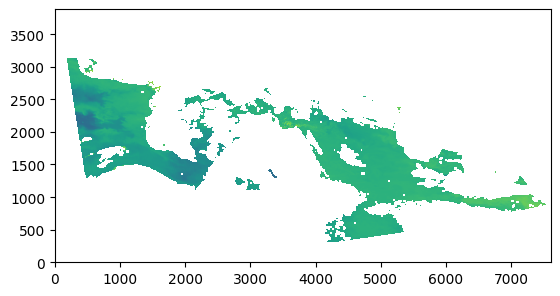

In [ ]:
chl_data = skio.imread(file)
plt.imshow(chl_data, origin='lower')
plt.show()

In [ ]:
time_fid = xr.open_dataset(os.path.join(download_dir,f'S3B_OL_2_WFR____20210717T093051_20210717T093351_20210718T215248_0179_054_364_1980_MAR_O_NT_003_time_coordinates.nc'))
time = time_fid.get('time_stamp').data
time_pd = pd.to_datetime(time)
time_np = time_pd.astype(np.int64)
average_time_np = np.average(time_np)

average_time_pd = pd.to_datetime(average_time_np)
print(average_time_pd)
write_tiff_to_nc(file, download_dir, average_time_pd)

2021-07-17 09:32:39.431571712


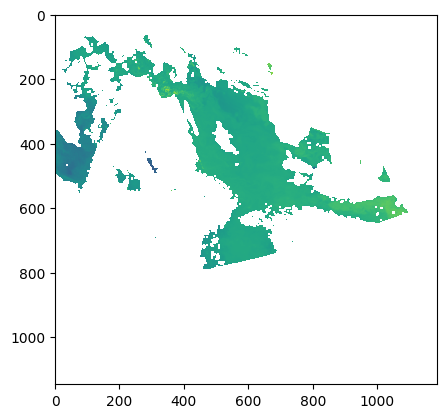

In [ ]:
path = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km'
multi_path = f"{path}/CHL_data_152016_to_2152016.nc"
multi = xr.open_dataset(multi_path)
rescale_nc_file(multi, download_dir, 'testing_indexing9.nc', average_time_pd)

In [ ]:
file = xr.open_dataset(f'{download_dir}/testing_indexing9.nc')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
file

<xarray.Dataset>
Dimensions:  (lat: 1147, lon: 1185, time: 1)
Coordinates:
  * lat      (lat) float32 53.26 53.27 53.28 53.29 ... 65.81 65.82 65.83 65.84
  * lon      (lon) float32 9.259 9.277 9.294 9.312 ... 30.19 30.21 30.22 30.24
  * time     (time) datetime64[ns] 2021-07-17T09:32:39.431570944
Data variables:
    data     (time, lat, lon) float32 ...

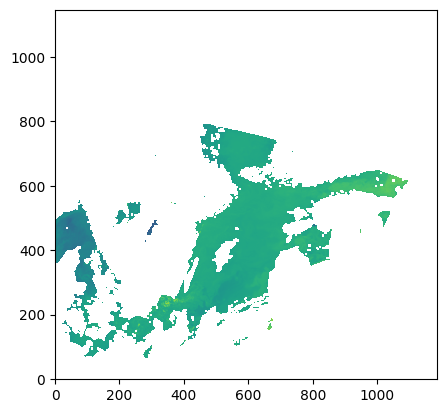

In [ ]:
plt.figure()
plt.imshow(file.data.data[0,:,:], origin='lower')
plt.show()

In [ ]:
# Merge data 
chl_nc_1 = xr.open_dataset(f"{download_dir}/S3B_OL_2_WFR____20210717T093051_20210717T093351_20210718T215248_0179_054_364_1980_MAR_O_NT_003_chl_nn.nc")
coordinates_nc = xr.open_dataset(f"{download_dir}/S3B_OL_2_WFR____20210717T093051_20210717T093351_20210718T215248_0179_054_364_1980_MAR_O_NT_003_geo_coordinates.nc")

In [ ]:
coordinates_nc

<xarray.Dataset>
Dimensions:    (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    altitude   (rows, columns) float32 ...
    latitude   (rows, columns) float64 ...
    longitude  (rows, columns) float64 ...
Attributes: (12/16)
    absolute_orbit_number:  16806
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2021-07-18T21:52:48Z
    ...                     ...
    references:             S3IPF PDS 004.3 - i2r3 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.01
    start_time:             2021-07-17T09:30:51.447723Z
    stop_time:              2021-07-17T09:33:51.415423Z
    title:                  OLCI Level 2 WATER Product, Geo Coordinates Data Set

In [ ]:
chl_nc_1

<xarray.Dataset>
Dimensions:     (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    CHL_NN      (rows, columns) float32 ...
    CHL_NN_err  (rows, columns) float32 ...
Attributes: (12/16)
    absolute_orbit_number:  16806
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2021-07-18T21:52:48Z
    ...                     ...
    references:             S3IPF PDS 004.3 - i2r3 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.01
    start_time:             2021-07-17T09:30:51.447723Z
    stop_time:              2021-07-17T09:33:51.415423Z
    title:                  OLCI Level 2 WATER Product, Neural Net Chlorophyl...

In [ ]:
grid_reduce = 10

geo_fid = coordinates_nc
# lat = geo_fid.get('latitude').data.flatten()
# lon = geo_fid.get('longitude').data.flatten()
lon = geo_fid.longitude.data[::grid_reduce, ::grid_reduce]
lat = geo_fid.latitude.data[::grid_reduce, ::grid_reduce]

chl_fid = chl_nc_1
chl_values = chl_fid.get('CHL_NN').data[::grid_reduce, ::grid_reduce]
chl_er_values = chl_fid.get('CHL_NN_err').data[::grid_reduce, ::grid_reduce]

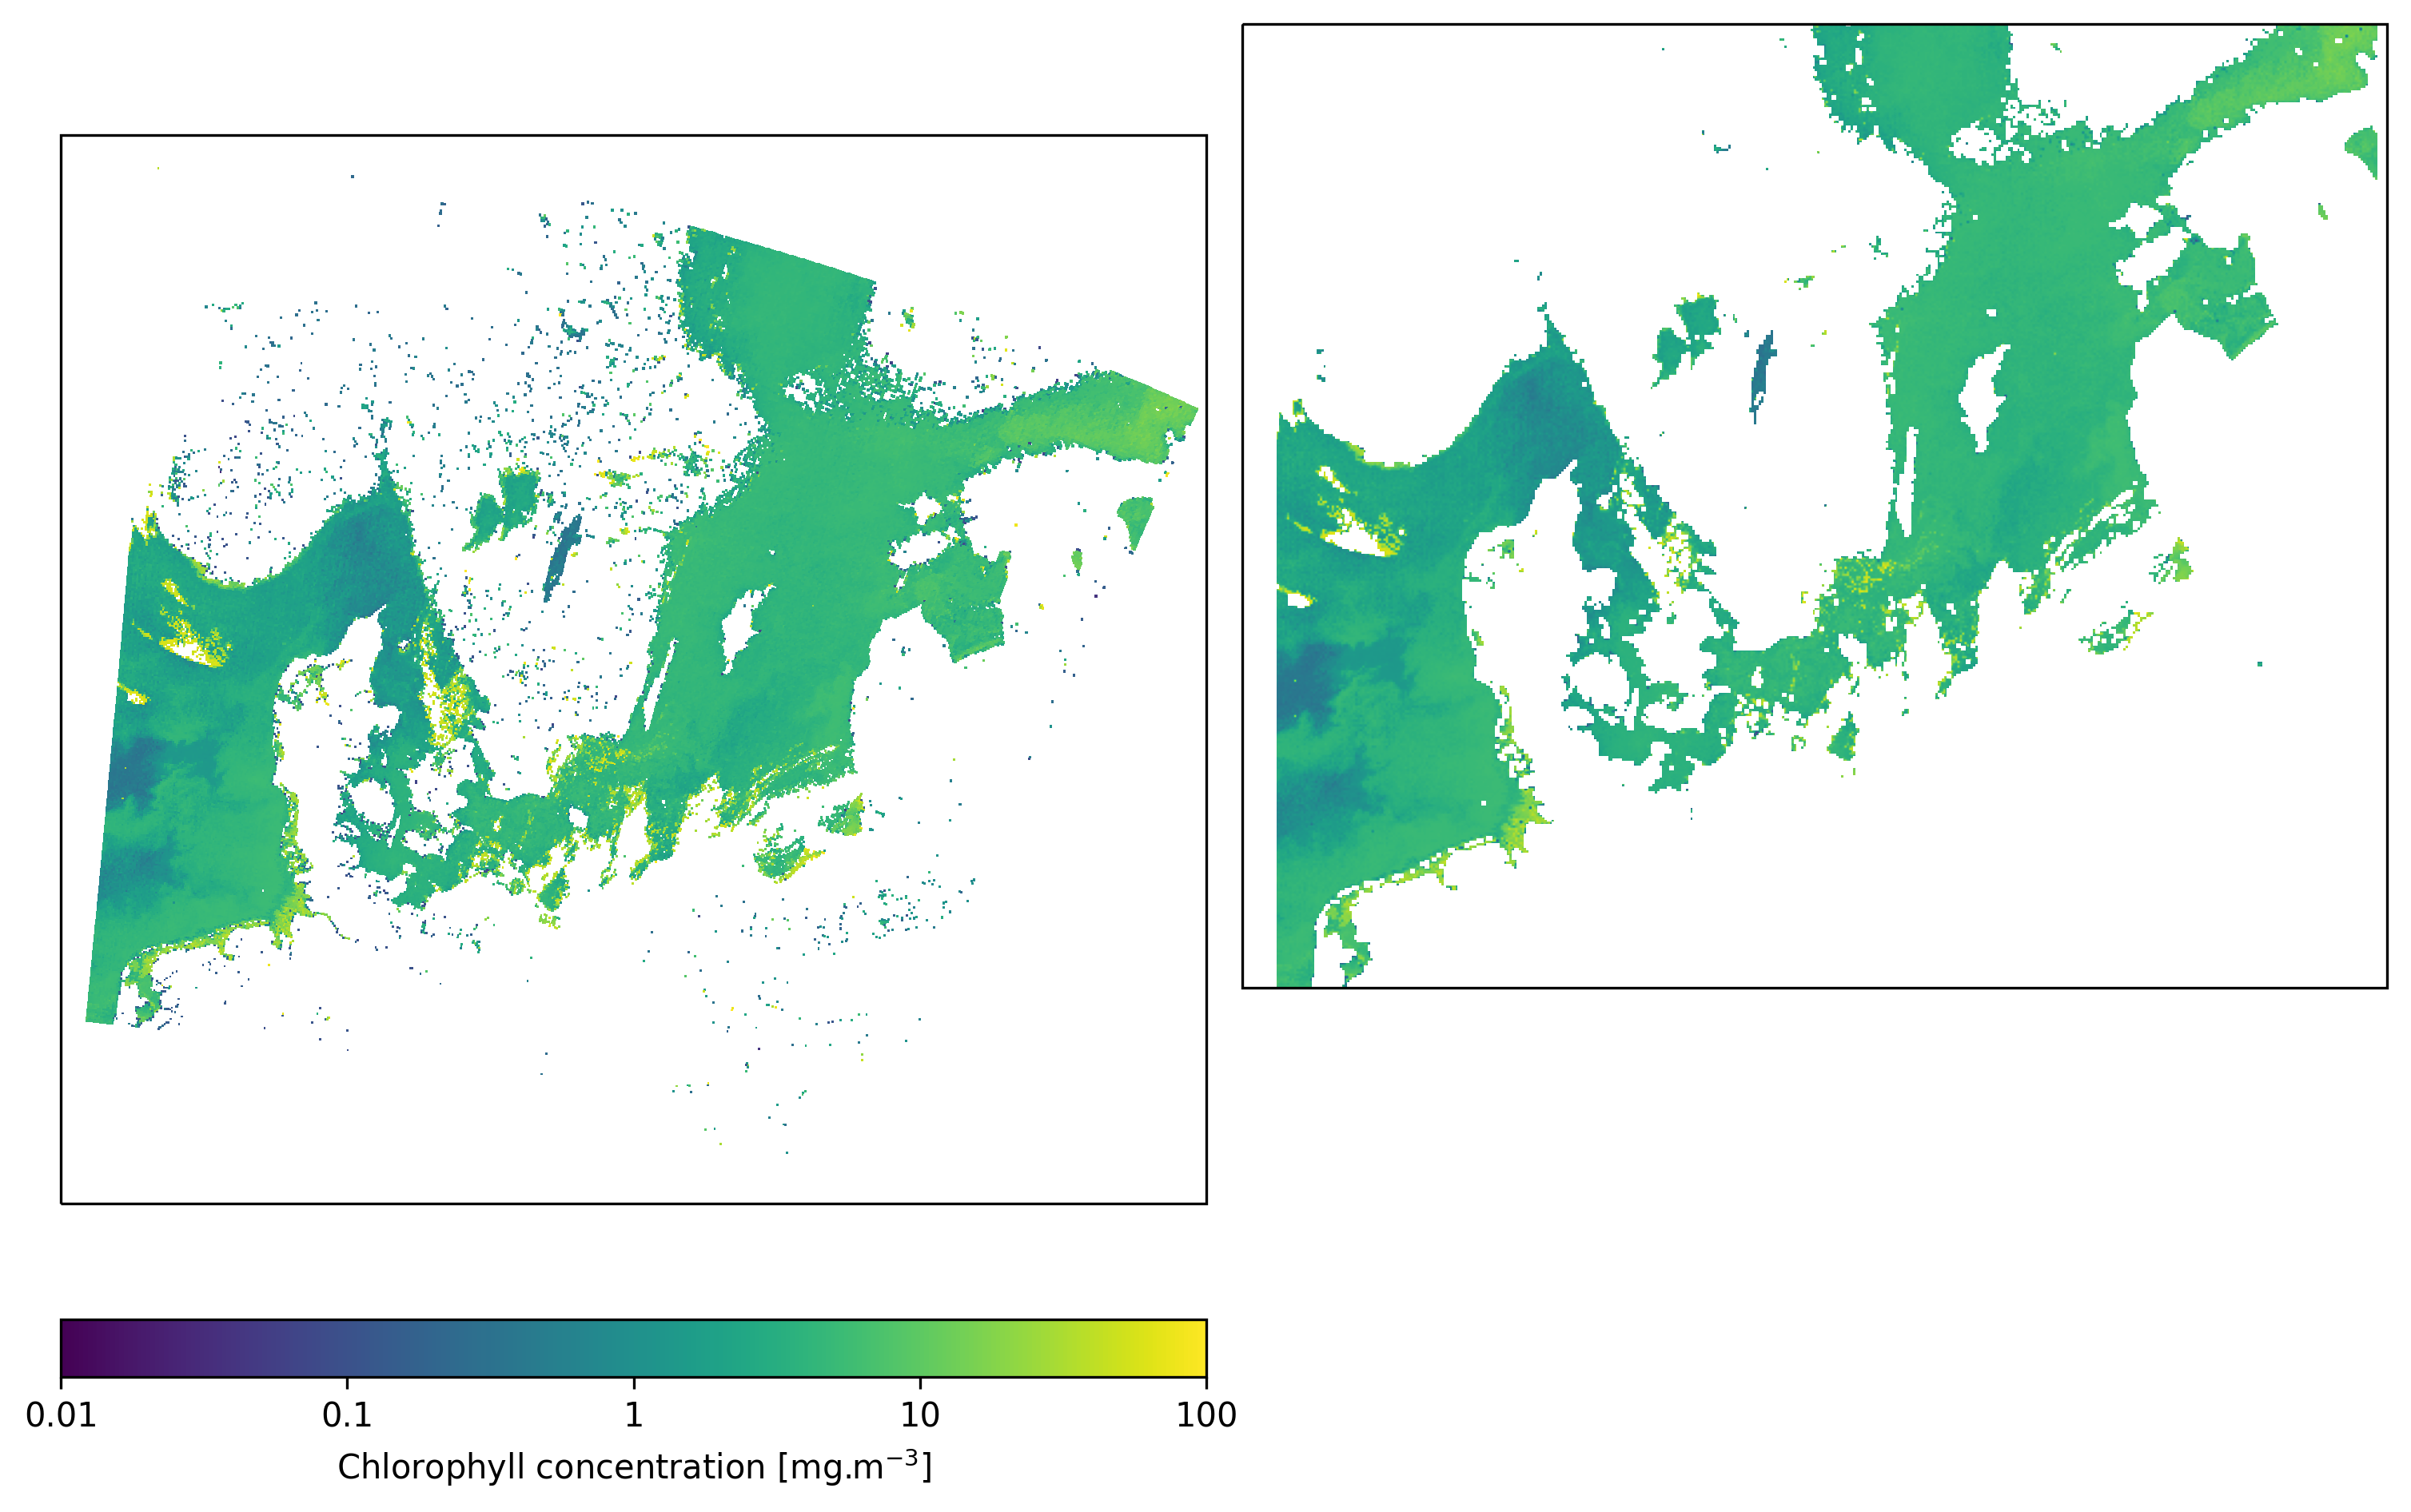

In [ ]:
# Define the larger extent to be plotted
lat_min, lat_max = 53.25 , 65.85
lon_min, lon_max = 9.253, 30.25
extent = [lon_min, lon_max, lat_min, lat_max]

fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": ccrs.Mercator()})
  
p1 = axs[0].pcolormesh(lon, lat, chl_values, transform=ccrs.PlateCarree(), 
                  cmap='viridis', vmin=-2, vmax=2, zorder=1)
axs[1].imshow(chl_values, cmap='viridis', vmin=-2, vmax=2, zorder=1)

#axs[0].set_extent(extent, crs=ccrs.PlateCarree())
# Embellish with gridlines
# g1 = axs.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
# g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
# g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
# g1.top_labels = False
# g1.right_labels = False
# g1.xlabel_style = {'color': 'black'}
# g1.ylabel_style = {'color': 'black'}
# axs.set(facecolor = "1.0")
# axs.axis('off')

plt.tight_layout()

cbar = fig.colorbar(p1, ax=axs[0], location='bottom', pad=0.05)
ticks = [-2,-1,0,1,2]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**tick for tick in ticks])
cbar.set_label('Chlorophyll concentration [mg.m$^{-3}$]')

In [ ]:
lat_min, lat_max = np.amin(lat), np.amax(lat)
lon_min, lon_max = np.amin(lon), np.amax(lon)

# determine the shape of your existing data
data_shape = chl_values.shape
print(data_shape)

# create an empty grid with the same shape as your existing data
grid_values = np.empty([len(lon.flatten()), len(lat.flatten())])

print(grid_values.shape)

# determine the indices of the grid cells that correspond to each latitude and longitude value in your existing data
lat_indices = ((lat.flatten() - lat_min) / (lat_max - lat_min) * len(np.unique(lat.flatten()))).astype(int)
lon_indices = ((lon.flatten() - lon_min) / (lon_max - lon_min) * len(np.unique(lon.flatten()))).astype(int)

print(np.max(lat_indices))
print(np.min(lat_indices))
print(np.max(lon_indices.shape))

print(grid_values[lon_indices, lat_indices].shape)

# assign the values from your existing data to the corresponding positions in the empty grid
grid_values[lat_indices, lon_indices] = chl_values.flatten()

plt.figure()
plt.imshow(grid_values)
plt.show()

(410, 487)
(199670, 199670)
197979
0
199670
(199670,)


ValueError: ignored

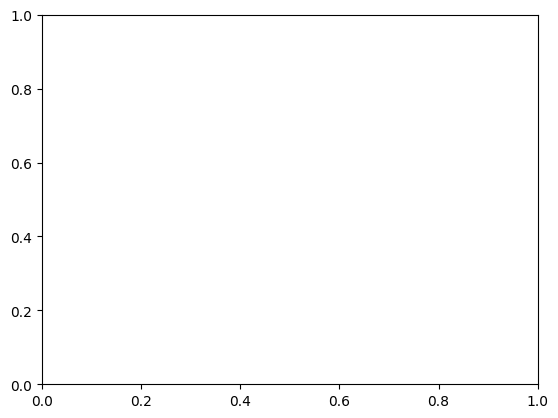

In [ ]:
xr.plot.pcolormesh(chl_nc_1.CHL_NN, transform=ccrs.PlateCarree())

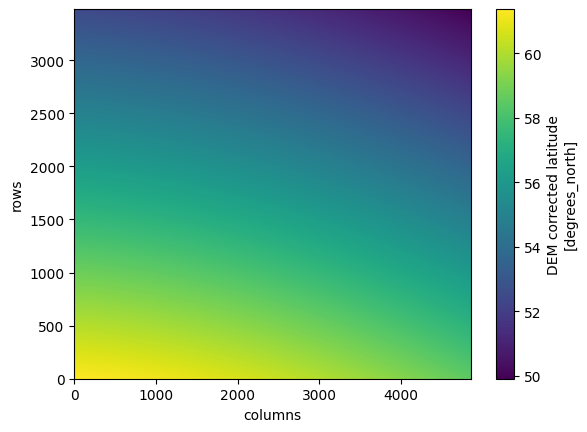

In [ ]:
xr.plot.pcolormesh(coordinates_nc.latitude)

## Code to access specifically the CHL data

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [ ]:
!conda install -c cmts eumartools 
!python -m pip install cartopy
import eumartools                   # a EUMETSAT library that support working with Sentinel-3 products
import cartopy.crs as ccrs          # a library that support mapping
import glob                         # a library that aids in searching for files
import matplotlib.pyplot as plt     # a library that support plotting
import matplotlib.ticker as mticker # a library that extends plotting support
import numpy as np                  # a library that provides support for array-based mathematics
import os                           # a library that allows us access to basic operating system commands like making directories
import warnings                     # a library that helps us manage warnings
import xarray as xr                 # a library that supports the use of multi-dimensional arrays in Python
warnings.filterwarnings('ignore')

# set plot font size
plt.rcParams.update({'font.size': 12})

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / 

ModuleNotFoundError: ignored

In [ ]:
SAFE_directory = os.path.join(os.getcwd(), 'TUTORIAL_products',
    'S3A_OL_2_WFR____20210717T101015_20210717T101315_20210718T221347_0179_074_122_1980_MAR_O_NT_003.SEN3')